# Setup (same everywhere)

## Mount Drive


In [2]:
from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

/content/drive/My Drive/repositories/moleculenet/notebooks


In [4]:
%ls

colab_extended_GPflow_pipeline.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
GPflow_regression_on_molecules.ipynb
visualise_extended_grid_search_results.ipynb
visualise_reproducing_grid_search_results.ipynb


In [5]:
%ls ../data/

esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original.csv
esol_original_extra_features.csv
esol_original_IdSmilesLabels.csv
esol_original_rdkit_features.csv
ESOL_README
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
FreeSolv_README
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv
Lipo_README


## Import modules

### Standard imports

In [6]:
import warnings
warnings.filterwarnings('ignore')

# custom imports
import os
import sys

# saving models
import json
import pickle

# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

# making custom metrics
from sklearn.metrics import make_scorer

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

# pipelines
# https://scikit-learn.org/stable/modules/compose.html#combining-estimators
from sklearn.pipeline import make_pipeline, Pipeline

In [7]:
try:
    import forestci as fci
    print("Successful import")
except ImportError as e:
    ! pip install forestci
    import forestci as fci

     |████████████████████████████████| 6.8MB 4.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Failed to import duecredit due to No module named 'duecredit'


In [8]:
import sklearn
print(sklearn.__version__)
print(fci.__version__)

0.22.2.post1
0.4.1


### Custom imports

In [9]:
sys.path.insert(0, '..')

# preprocessing
from util_scripts.preprocessing_functions import list_highly_correlated

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels

sys.path.insert(0, './notebooks')

In [10]:
help(list_highly_correlated)

Help on function list_highly_correlated in module util_scripts.preprocessing_functions:

list_highly_correlated(df_features, targets, threshold=0.8)
    List column names of the dataframe of features which are highly correlated
    to the target (absolute value of the correlation is greater than the threshold).
    
    Parameters
    ----------
    df_features : (n, p) pandas.core.frame.DataFrame of p features
                  Input array.
    targets     : (n,) pandas.core.series.Series of targets
                  Input array.
    threshold   : float in [0, 1] above which we consider a feature highly correlated
    
    Returns
    -------
    cols_to_remove : list of column names from df_features, which are highly correlated
                     to the target



## Set plotting style

In [11]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# Load Data (same everywhere)

## CHOOSE: dataset, smile_type, grid_search_type

In [12]:
dataset = 'esol'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'reproducing'
assert grid_search_type in ['reproducing', 'extended']

In [13]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [14]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


## Load Features and Targets

Leave all features here so setup and Load and prepare data are the same everywhere.

In [15]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmilesLabels.csv', index_col=0)
# labels
labels = id_smile_target['labels']

In [16]:
# fingerprints
ecfp4_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp4_features.csv', index_col=0)
ecfp6_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp6_features.csv', index_col=0)

ecfp4_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp4_features.csv', index_col=0)
ecfp6_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp6_features.csv', index_col=0)

In [17]:
# RDKit descriptors
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)

highly_correlated_features = list_highly_correlated(rdkit_features, labels, threshold=0.75)

print(f'\nRemoving {len(highly_correlated_features)} highly correlated feature(s).')
rdkit_features = rdkit_features.drop(highly_correlated_features, axis=1)


Found 1 highly-correlated feature(s):
['MolLogP']

Removing 1 highly correlated feature(s).


In [18]:
print('rdkit_features.shape:      ', rdkit_features.shape)
print('ecfp4_1024_features.shape: ', ecfp4_1024_features.shape)
print('ecfp6_1024_features.shape: ', ecfp6_1024_features.shape)
print('ecfp4_2048_features.shape: ', ecfp4_2048_features.shape)
print('ecfp6_2048_features.shape: ', ecfp6_2048_features.shape)
print('labels.shape:              ', labels.shape)

rdkit_features.shape:       (1128, 199)
ecfp4_1024_features.shape:  (1128, 1024)
ecfp6_1024_features.shape:  (1128, 1024)
ecfp4_2048_features.shape:  (1128, 2048)
ecfp6_2048_features.shape:  (1128, 2048)
labels.shape:               (1128,)


In [19]:
labels.head()

id
Amigdalin   -0.77
Fenfuram    -3.30
citral      -2.06
Picene      -7.87
Thiophene   -1.33
Name: labels, dtype: float64

## Create one DataFrame with all features

In [20]:
all_features = pd.concat([rdkit_features,
                          ecfp4_1024_features, ecfp6_1024_features,
                          ecfp4_2048_features, ecfp6_2048_features],
                         axis='columns')

In [21]:
all_features.shape

(1128, 6343)

In [22]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,...,2048ecfp6-2008,2048ecfp6-2009,2048ecfp6-2010,2048ecfp6-2011,2048ecfp6-2012,2048ecfp6-2013,2048ecfp6-2014,2048ecfp6-2015,2048ecfp6-2016,2048ecfp6-2017,2048ecfp6-2018,2048ecfp6-2019,2048ecfp6-2020,2048ecfp6-2021,2048ecfp6-2022,2048ecfp6-2023,2048ecfp6-2024,2048ecfp6-2025,2048ecfp6-2026,2048ecfp6-2027,2048ecfp6-2028,2048ecfp6-2029,2048ecfp6-2030,2048ecfp6-2031,2048ecfp6-2032,2048ecfp6-2033,2048ecfp6-2034,2048ecfp6-2035,2048ecfp6-2036,2048ecfp6-2037,2048ecfp6-2038,2048ecfp6-2039,2048ecfp6-2040,2048ecfp6-2041,2048ecfp6-2042,2048ecfp6-2043,2048ecfp6-2044,2048ecfp6-2045,2048ecfp6-2046,2048ecfp6-2047
Amigdalin,10.069684,-5.122500,10.069684,0.911295,0.217518,457.432,430.216,457.158411,178.0,0.0,0.210849,-0.393567,0.393567,0.210849,0.781250,1.312500,1.843750,2.512447,1822.972785,46.449383,41.937945,14.937945,26.489135,20.643207,7.785469,5.261208,5.261208,3.350174,3.350174,1.916053,1.916053,-1.73,4.967252e+11,7.382237,10.926356,5.251706,221.476223,54.709109,48.640144,18.612175,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fenfuram,12.547837,-2.999280,12.547837,0.099444,0.811283,201.225,190.137,201.078979,76.0,0.0,0.258698,-0.468799,0.468799,0.258698,1.333333,2.066667,2.800000,2.680215,872.797237,20.135310,18.263710,7.263710,11.801324,9.256800,3.809586,2.423811,2.423811,1.470204,1.470204,0.842712,0.842712,-2.03,3.091769e+05,2.980514,4.002882,2.070849,103.236827,9.726964,7.131006,1.411842,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
citral,11.071016,-3.884051,11.071016,1.707414,0.343706,152.237,136.109,152.120115,62.0,0.0,0.142281,-0.298566,0.298566,0.142281,1.181818,1.909091,2.454545,7.099519,638.159152,22.386751,21.408248,5.408248,11.502777,10.454124,2.454124,1.352062,1.352062,0.551031,0.551031,0.238531,0.238531,-0.85,9.152531e+04,1.343483,5.899351,7.042356,91.285574,0.000000,7.632971,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Picene,8.745488,-0.641794,8.745488,0.260568,0.291526,278.354,264.242,278.109550,102.0,0.0,0.062969,-0.061629,0.062969,0.061629,0.227273,0.409091,0.772727,2.297464,1736.538251,26.701706,25.000000,11.000000,16.749570,13.500000,6.500000,4.750000,4.750000,3.562500,3.562500,2.562500,2.562500,-2.86,7.369089e+07,4.565966,4.315741,1.523286,147.827648,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Thiophene,6.980324,-0.134259,6.980324,0.004630,0.448927,84.143,80.111,84.003371,26.0,0.0,0.073940,-0.152454,0.152454,0.073940,1.400000,2.000000,2.200000,3.292166,206.216662,7.016508,6.408248,3.224745,4.125898,3.158248,1.974745,0.556186,1.168559,0.266624,0.674872,0.127578,0.382733,-0.30,1.091618e+02,0.850086,1.221050,0.484065,40.691648,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# CHOOSE: what feature_sets we will iterate over

## Put original features into feature_sets
Create a dictionary containing feature names (index objects) as its elements

In [23]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    '1024ecfp-4': ecfp4_1024_features.columns,
    '1024ecfp-6': ecfp6_1024_features.columns,
    '2048ecfp-4': ecfp4_2048_features.columns,
    '2048ecfp-6': ecfp6_2048_features.columns,
}

## Adding a combination of RDKit features with every feature set in the feature_sets dictionary


In [24]:
for f in ['1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])

In [25]:
list(feature_sets.keys())

['RDKit',
 '1024ecfp-4',
 '1024ecfp-6',
 '2048ecfp-4',
 '2048ecfp-6',
 '1024ecfp-4 + RDKit',
 '1024ecfp-6 + RDKit',
 '2048ecfp-4 + RDKit',
 '2048ecfp-6 + RDKit']

# Getting CIs

In [26]:
# feature set
f = '1024ecfp-4'

In [27]:
estimators = {
    'rf':  RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'krr': KernelRidge(kernel='rbf'), # 'rbf' used in the paper (defaults to 'linear')
    'gp': GaussianProcessRegressor(normalize_y=True), # normilize since we have not normalized here
}

## Load best parameters

In [28]:
with open(f'../results/{dataset}_{smile_type}_{grid_search_type}_random_search_best_params.pickle', 'rb') as fp:
    best_params = pickle.load(fp)

In [29]:
best_params

{'1024ecfp-4': {'gp': {'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)},
  'krr': {'krr__alpha': 0.01},
  'rf': {'rf__n_estimators': 500},
  'xgb': {'xgb__learning_rate': 0.3,
   'xgb__max_depth': 3,
   'xgb__n_estimators': 350}}}

In [30]:
X = all_features[feature_sets[f]]
y = labels[X.index]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Run RF with best parameters on the selected feature set

In [32]:
e = 'rf'

In [33]:
print(best_params[f][e])

{'rf__n_estimators': 500}


In [34]:
rf = RandomForestRegressor(n_estimators=500,
                           random_state=42, n_jobs=-1,
                           verbose = 1)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [35]:
y_test_pred = rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [36]:
y_train_pred = rf.predict(X_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


## Plot the results for test and train observations

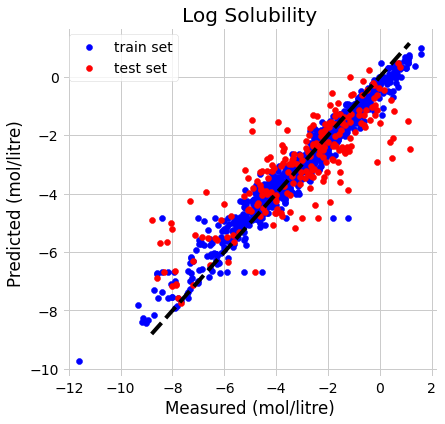

In [37]:
# Plot predicted logD without error bars
plt.figure(figsize=FIGSIZE_CI)
plt.tight_layout()

plt.scatter(y_train, y_train_pred, color='blue', label='train set')
plt.scatter(y_test, y_test_pred, color='red', label='test set')

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

plt.legend()

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

# Confidence Intervals

## Calculate confidence bounds using forestci

In [38]:
# Calculate the variance
V_IJ_unbiased = fci.random_forest_error(rf, X_train, X_test)

In [39]:
print(len(V_IJ_unbiased))
V_IJ_unbiased[:20]

226


array([1.17292446, 0.57129953, 0.79527236, 1.17292446, 3.4629965 ,
       0.47261043, 0.44109915, 0.54742962, 4.30505637, 0.47761214,
       0.58380997, 2.19967232, 0.44000429, 0.46692037, 0.50583163,
       1.11281968, 0.6486003 , 3.37587233, 0.48627262, 0.54054213])

In [40]:
upper = y_test_pred + 1.96 * np.sqrt(V_IJ_unbiased)
lower = y_test_pred - 1.96 * np.sqrt(V_IJ_unbiased)

In [66]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'std': np.sqrt(V_IJ_unbiased),
     'lower': lower,
     'upper': upper,
     'sq_error': (y_test - y_test_pred) ** 2
     }
)
CIs_df = CIs_df.sort_values(by='y_test')

In [55]:
display(CIs_df.head())

print('\n...\n')

display(CIs_df.tail())

,y_test,y_test_pred,std,lower,upper,sq_error
Perylene,-8.804,-4.904684,1.277194,-7.407984,-2.401384,15.204665
"2,2',3,3',5,6-PCB",-8.600,-6.901588,1.854420,-10.536250,-3.266926,2.884603
Benzo(k)fluoranthene,-8.490,-5.685574,1.358583,-8.348398,-3.022750,7.864805
hexacosane,-8.334,-6.689817,1.837355,-10.291032,-3.088601,2.703339
Benzo(b)fluoranthene,-8.230,-5.646510,1.261485,-8.119020,-3.174000,6.674421



...



,y_test,y_test_pred,std,lower,upper,sq_error
Acephate,0.540,-1.163428,1.483129,-4.070361,1.743505,2.901667
Erythritol,0.700,0.467400,1.703539,-2.871536,3.806336,0.054103
Pyridine,0.760,0.343408,1.498945,-2.594523,3.281339,0.173549
2-pyrrolidone,1.070,-1.526456,0.974857,-3.437176,0.384263,6.741585
vamidothion,1.144,-2.474265,1.207543,-4.841050,-0.107481,13.091844


## Plot test observations with error bars (1 std.)

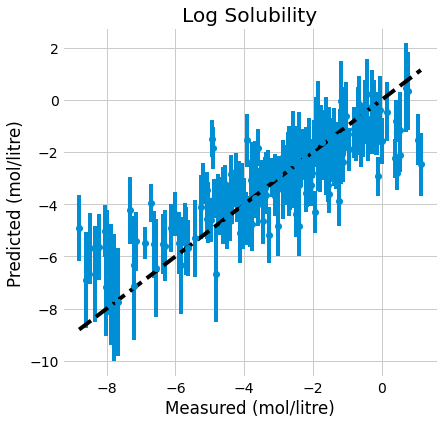

In [51]:
# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.errorbar(x=CIs_df['y_test'], y=CIs_df['y_test_pred'], yerr=CIs_df['std'], fmt='o')
plt.plot([np.min(CIs_df['y_test']), np.max(CIs_df['y_test'])],
         [np.min(CIs_df['y_test']), np.max(CIs_df['y_test'])],
         'k--')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

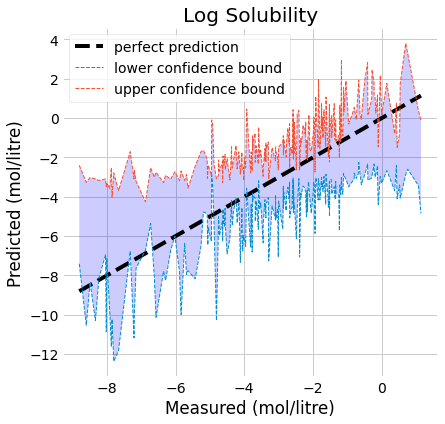

In [56]:
fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df['y_test'], CIs_df['lower'], linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df['y_test'], CIs_df['upper'], linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df['y_test'], CIs_df['upper'], CIs_df['lower'], facecolor='blue', alpha=0.2)

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

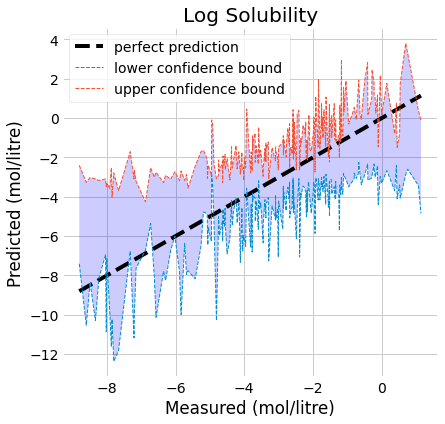

In [44]:
plt.figure(figsize=FIGSIZE_CI)

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

plt.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
plt.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
plt.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

plt.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [57]:
within_cis = (CIs_df['lower'] <= CIs_df['y_test']) & (CIs_df['y_test'] <= CIs_df['upper'])
within_cis

Perylene                False
2,2',3,3',5,6-PCB        True
Benzo(k)fluoranthene    False
hexacosane               True
Benzo(b)fluoranthene    False
                        ...  
Acephate                 True
Erythritol               True
Pyridine                 True
2-pyrrolidone           False
vamidothion             False
Length: 226, dtype: bool

In [58]:
within_cis.sum() / len(within_cis)

0.8716814159292036

## Produce confiidence plots

In [103]:
CIs_df = CIs_df.sort_values(by='std', ascending=True)
display(CIs_df)

,y_test,y_test_pred,std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
cycloate,-3.400,-3.390631,0.612588,-4.591304,-2.189958,0.000088,312.535780,1.382902,1.175968
Santonin,-3.090,-2.691928,0.625405,-3.917722,-1.466134,0.158461,312.535693,1.389048,1.178579
Flucythrinate,-6.876,-5.484424,0.626281,-6.711935,-4.256913,1.936484,312.377231,1.394541,1.180907
Dioxacarb,-1.570,-2.495890,0.643023,-3.756216,-1.235564,0.857272,310.440747,1.392111,1.179878
Trichlomethiazide,-2.680,-3.799776,0.646684,-5.067277,-2.532275,1.253898,309.583475,1.394520,1.180898
...,...,...,...,...,...,...,...,...,...
Cypermethrin,-8.017,-7.168444,1.884393,-10.861855,-3.475033,0.720047,1.412247,0.282449,0.531460
"2,2',3,4,5-PCB",-7.210,-7.131050,2.061705,-11.171992,-3.090108,0.006233,0.692200,0.173050,0.415993
"2,3,3',4,4'6-PCB",-7.660,-7.752472,2.074863,-11.819203,-3.685741,0.008551,0.685967,0.228656,0.478180
Picene,-7.870,-7.077584,2.324223,-11.633061,-2.522107,0.627923,0.677416,0.338708,0.581986


In [104]:
CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
display(CIs_df)

,y_test,y_test_pred,std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
cycloate,-3.400,-3.390631,0.612588,-4.591304,-2.189958,0.000088,0.000088,1.382902,1.175968
Santonin,-3.090,-2.691928,0.625405,-3.917722,-1.466134,0.158461,0.158549,1.389048,1.178579
Flucythrinate,-6.876,-5.484424,0.626281,-6.711935,-4.256913,1.936484,2.095033,1.394541,1.180907
Dioxacarb,-1.570,-2.495890,0.643023,-3.756216,-1.235564,0.857272,2.952305,1.392111,1.179878
Trichlomethiazide,-2.680,-3.799776,0.646684,-5.067277,-2.532275,1.253898,4.206203,1.394520,1.180898
...,...,...,...,...,...,...,...,...,...
Cypermethrin,-8.017,-7.168444,1.884393,-10.861855,-3.475033,0.720047,311.843580,0.282449,0.531460
"2,2',3,4,5-PCB",-7.210,-7.131050,2.061705,-11.171992,-3.090108,0.006233,311.849813,0.173050,0.415993
"2,3,3',4,4'6-PCB",-7.660,-7.752472,2.074863,-11.819203,-3.685741,0.008551,311.858364,0.228656,0.478180
Picene,-7.870,-7.077584,2.324223,-11.633061,-2.522107,0.627923,312.486287,0.338708,0.581986


In [105]:
CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
display(CIs_df)

,y_test,y_test_pred,std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
cycloate,-3.400,-3.390631,0.612588,-4.591304,-2.189958,0.000088,0.000088,0.000088,1.175968
Santonin,-3.090,-2.691928,0.625405,-3.917722,-1.466134,0.158461,0.158549,0.079275,1.178579
Flucythrinate,-6.876,-5.484424,0.626281,-6.711935,-4.256913,1.936484,2.095033,0.698344,1.180907
Dioxacarb,-1.570,-2.495890,0.643023,-3.756216,-1.235564,0.857272,2.952305,0.738076,1.179878
Trichlomethiazide,-2.680,-3.799776,0.646684,-5.067277,-2.532275,1.253898,4.206203,0.841241,1.180898
...,...,...,...,...,...,...,...,...,...
Cypermethrin,-8.017,-7.168444,1.884393,-10.861855,-3.475033,0.720047,311.843580,1.404701,0.531460
"2,2',3,4,5-PCB",-7.210,-7.131050,2.061705,-11.171992,-3.090108,0.006233,311.849813,1.398430,0.415993
"2,3,3',4,4'6-PCB",-7.660,-7.752472,2.074863,-11.819203,-3.685741,0.008551,311.858364,1.392225,0.478180
Picene,-7.870,-7.077584,2.324223,-11.633061,-2.522107,0.627923,312.486287,1.388828,0.581986


In [110]:
CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
display(CIs_df)

,y_test,y_test_pred,std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
cycloate,-3.400,-3.390631,0.612588,-4.591304,-2.189958,0.000088,0.000088,0.000088,0.009369
Santonin,-3.090,-2.691928,0.625405,-3.917722,-1.466134,0.158461,0.158549,0.079275,0.281557
Flucythrinate,-6.876,-5.484424,0.626281,-6.711935,-4.256913,1.936484,2.095033,0.698344,0.835670
Dioxacarb,-1.570,-2.495890,0.643023,-3.756216,-1.235564,0.857272,2.952305,0.738076,0.859114
Trichlomethiazide,-2.680,-3.799776,0.646684,-5.067277,-2.532275,1.253898,4.206203,0.841241,0.917192
...,...,...,...,...,...,...,...,...,...
Cypermethrin,-8.017,-7.168444,1.884393,-10.861855,-3.475033,0.720047,311.843580,1.404701,1.185201
"2,2',3,4,5-PCB",-7.210,-7.131050,2.061705,-11.171992,-3.090108,0.006233,311.849813,1.398430,1.182552
"2,3,3',4,4'6-PCB",-7.660,-7.752472,2.074863,-11.819203,-3.685741,0.008551,311.858364,1.392225,1.179926
Picene,-7.870,-7.077584,2.324223,-11.633061,-2.522107,0.627923,312.486287,1.388828,1.178485


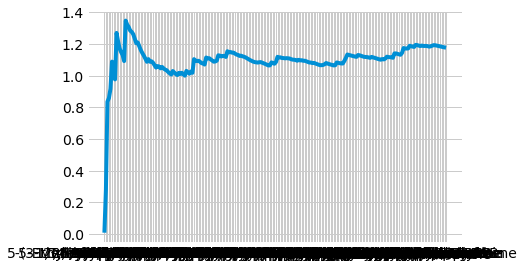

In [108]:
plt.plot(CIs_df['cumul_rmse'])

In [113]:
confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))

In [118]:
CIs_df['cumul_rmse'].values[::-1]

array([1.1759684 , 1.17848545, 1.17992578, 1.18255218, 1.18520075,
       1.18650697, 1.18916908, 1.19140806, 1.19262848, 1.18980009,
       1.18567209, 1.18312439, 1.18577888, 1.1875412 , 1.18719779,
       1.18739316, 1.18986971, 1.18687845, 1.18969929, 1.19256375,
       1.1944356 , 1.18121586, 1.18323329, 1.18587326, 1.18864988,
       1.17158238, 1.17102118, 1.17142462, 1.17397884, 1.14369635,
       1.13166331, 1.1344722 , 1.13739167, 1.14033326, 1.14020138,
       1.11279922, 1.11535502, 1.11672681, 1.1174207 , 1.11954618,
       1.1079465 , 1.10265552, 1.10483474, 1.10049515, 1.10293035,
       1.10596871, 1.10893677, 1.11192993, 1.11504895, 1.11819289,
       1.11237341, 1.11488785, 1.11709894, 1.11792771, 1.11865397,
       1.12190631, 1.12519589, 1.12845363, 1.13014364, 1.11849512,
       1.12034335, 1.12274743, 1.12528378, 1.12730313, 1.13060358,
       1.13329463, 1.1115057 , 1.09284475, 1.07666164, 1.07704288,
       1.07835557, 1.08074913, 1.08345894, 1.06569803, 1.06458

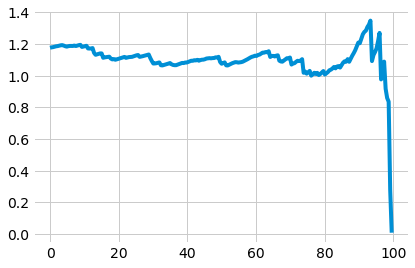

In [120]:
plt.plot(confidence_percentiles, CIs_df['cumul_rmse'].values[::-1])